# DeNoising Convolutional Neural Network for Cifar dataset

## Backend and Import

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

tensorflow


In [2]:
import keras
from keras.models import load_model
from keras.datasets import cifar10
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np

Using TensorFlow backend.


## Load Cifar10 dataset

In [3]:
batch_size = 32
num_classes = 10
epochs = 100
saveDir = "/opt/files/python/transfer/ae/"
if not os.path.isdir(saveDir):
    os.makedirs(saveDir)

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train_line = np.copy(x_train)
x_test_line = np.copy(x_test)

## draw black lines to data

In [5]:
def drawLines(x):
    for i in range(len(x)):
        numLines = np.random.randint(20) + 1
        for l in range(numLines):
            if l % 2 == 0:
                vh = np.random.randint(2)
                start = np.random.randint(10)
                length = start + np.random.randint(4,21)
                position = np.random.randint(32)
                for j in range(3):
                    if vh == 0:
                        x[i,:,:,j][start:length, position] = 0
                    else:
                        x[i,:,:,j][position, start:length] = 0
            else:
                vh = np.random.randint(2)
                start = np.random.randint(10,25)
                length = start + np.random.randint(5,32-start)
                position = np.random.randint(32)
                for j in range(3):
                    if vh == 0:
                        x[i,:,:,j][start:length, position] = 0
                    else:
                        x[i,:,:,j][position, start:length] = 0
    return x

In [6]:
x_train_line = drawLines(x_train_line)
x_test_line = drawLines(x_test_line)

## normalize data

In [7]:
# normalize data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# normalize data
x_train_line = x_train_line.astype('float32')
x_test_line = x_test_line.astype('float32')
x_train_line /= 255
x_test_line /= 255

In [8]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## show noisy images

In [9]:
# definition to show original image and reconstructed image
def showOrigDec(orig, noise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

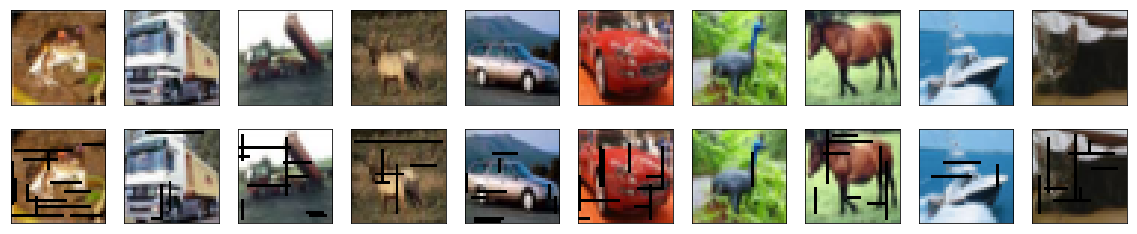

In [10]:
showOrigDec(x_train, x_train_line)

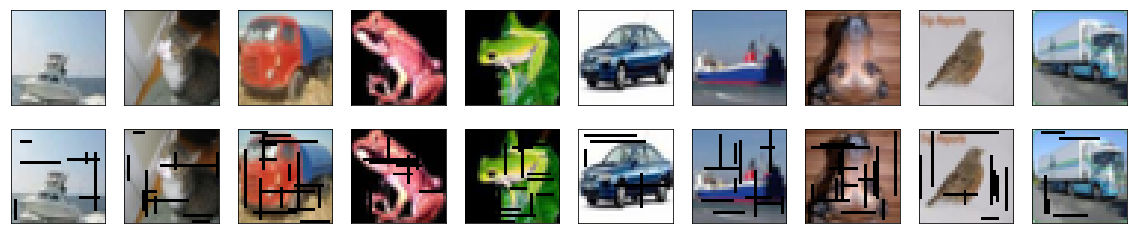

In [11]:
showOrigDec(x_train[100:], x_train_line[100:])

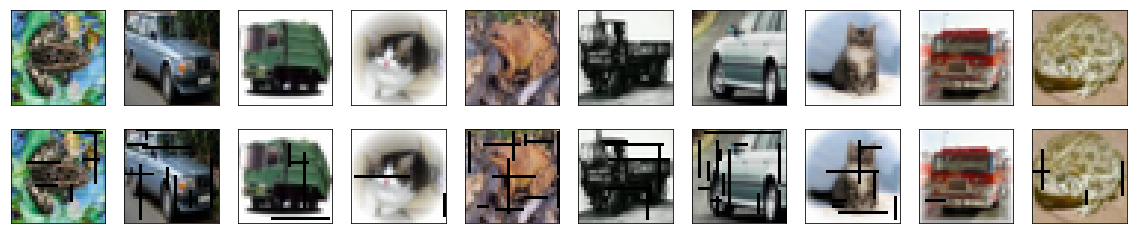

In [12]:
showOrigDec(x_train[200:], x_train_line[200:])

## DNCNN

In [13]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = Activation('relu')(x)

for i in range(15):
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

x = Conv2D(3, (3, 3), padding='same')(x)
output_img = Activation('tanh')(x)

In [14]:
model = Model(input_img, output_img)
model.compile(optimizer='adam', loss='mean_squared_error')

## Train CNN

In [25]:
# load pretrained weights
# model.load_weights(saveDir + "AutoEncoder_Cifar10_dncnn_weights.02-0.00-0.00.hdf5")

In [16]:
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
chkpt = saveDir + 'AutoEncoder_Cifar10_dncnn_weights.{epoch:02d}-{loss:.2f}-{val_loss:.2f}.hdf5'
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [17]:
history = model.fit(x_train_line, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test_line, x_test),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 276s - loss: 7.1583e-04 - val_loss: 9.5072e-04
Epoch 2/100
50000/50000 [==============================] - 275s - loss: 7.1186e-04 - val_loss: 0.0017
Epoch 3/100
50000/50000 [==============================] - 275s - loss: 6.2523e-04 - val_loss: 6.3866e-04
Epoch 4/100
50000/50000 [==============================] - 275s - loss: 8.0618e-04 - val_loss: 0.0033
Epoch 5/100
50000/50000 [==============================] - 275s - loss: 7.9862e-04 - val_loss: 7.7228e-04
Epoch 6/100
50000/50000 [==============================] - 275s - loss: 6.3246e-04 - val_loss: 9.0408e-04
Epoch 00005: early stopping


## Evaluate with test dataset

In [26]:
score = model.evaluate(x_test_line, x_test, verbose=1)
print(score)

 9984/10000 [============================>.] - ETA: 0s0.000638661881443


## Visualize original image, noisy image and denoised image

In [27]:
c10test = model.predict(x_test_line)

In [29]:
# definition to show original image and reconstructed image
def showOrigDec(orig, noise, denoise, num=10):
    import matplotlib.pyplot as plt
    n = num
    plt.figure(figsize=(20, 6))

    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display noisy image
        ax = plt.subplot(3, n, i +1 + n)
        plt.imshow(noise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display denoised image
        ax = plt.subplot(3, n, i +1 + n + n)
        plt.imshow(denoise[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

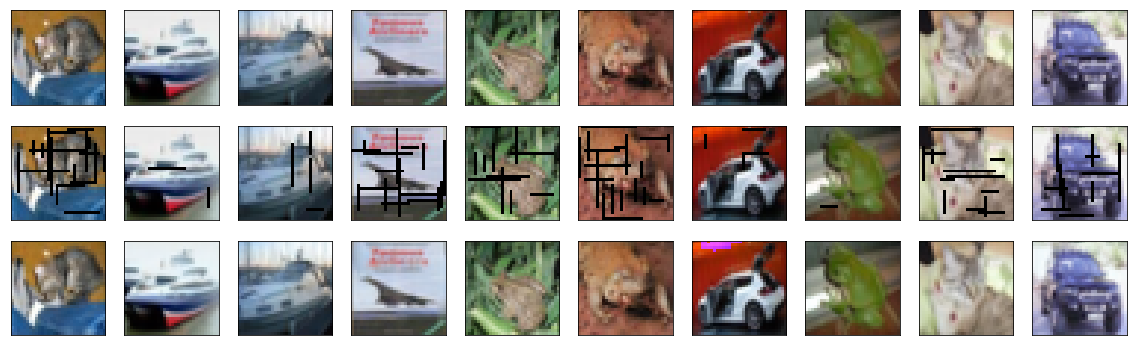

In [30]:
showOrigDec(x_test, x_test_line, c10test)

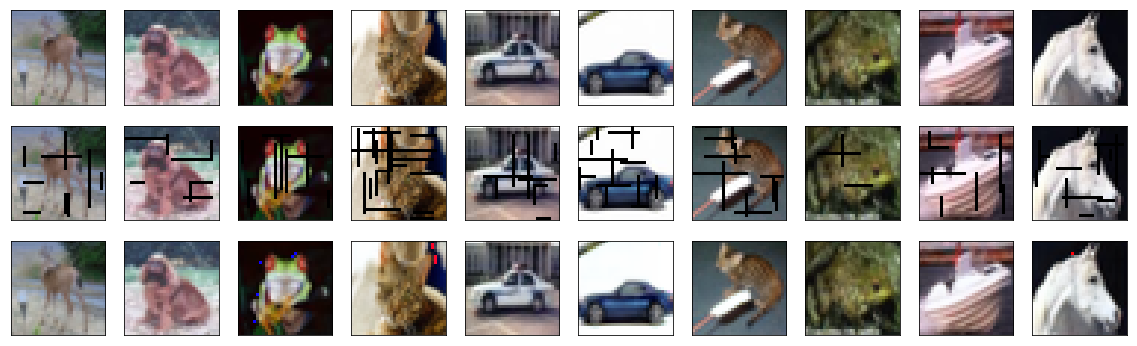

In [31]:
showOrigDec(x_test[100:], x_test_line[100:], c10test[100:])

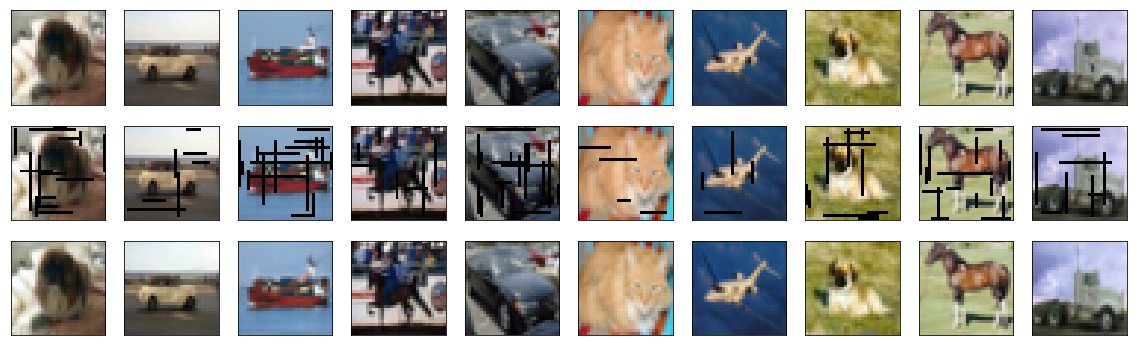

In [32]:
showOrigDec(x_test[200:], x_test_line[200:], c10test[200:])